# MATH 3094 Project 2 - Wheat Seeds Classification, A Comparison of Models
The Wheat Seeds data set comes from the Institute of Agrophysics of the Polish Academy of Sciences in Lubin. It was originally used in a research paper on a gradient clustering algorithm.  
  
The dataset contains a collection of information about 210 wheat seeds. The data comes from images recorded on 13x18 cm X-ray KODAK plates. The attributes are:
  
  - Area  
  - Perimeter  
  - Compactness  
  - Kernel Length  
  - Kernal Width  
  - Asymmetry Coeff  
  - Kernel Groove  

The seeds are classified by type of seed. The types are specified as follows:
  1. Kama
  2. Rosa
  3. Canadian
  
The dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/jmcaro/wheat-seedsuci?resource=download) and UC Irvine Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/seeds).

Here we start by importing the necessary modules and data, and dividing the data into train and test sets.


In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import CategoricalColorMapper

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

output_notebook()

Loading BokehJS ...

In [3]:
pandas_data = pd.read_csv("seeds.csv")

data = np.genfromtxt("seeds.csv",delimiter=',',skip_header=1, usecols=[0, 1, 2, 3, 4, 5, 6])
attributes = np.genfromtxt("seeds.csv",delimiter=',',dtype=str, max_rows=1, usecols=[0, 1, 2, 3, 4, 5, 6])
labels = np.genfromtxt("seeds.csv", delimiter=',', dtype=int, usecols=7, skip_header=1)

data_train, data_test, labels_train, labels_test = train_test_split(data,labels,test_size=.2)
pandas_data.head()

Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   Asymmetry.Coeff  Kernel.Groove  Type  
0            2.221          5.220     1  
1            1.018          4.956     1  
2            2.699          4.825     1  
3            2.259          4.805     1  
4            1.355          5.175     1

---
## The Support Vector Machine
This section focuses on the use of a support vector machine for classification. This is first done performing multi-class classification on the dataset. This is begun with a little data preprocessing. SVM is not scale invariant, so its best to normalize the data to mean 0 and variance one. That is done below.

In [4]:
data_normalized = normalize(data_train, axis=0, norm='l1')

Now the data model can be created and fit using Sci Kit Learn's SVM model. Through experimenting, it was found that the RBF kernel and the linear kernel represented the data best. By adjusting C to 10, the linear kernel's accuracy was improved from 92.5% to 97.5%, same as the RBF kernel. Here the linear model is used, since it is more efficient.

In [46]:
SVM_Model = SVC(kernel="linear", C=10).fit(data_train, labels_train)

Here the score of the model is calculated on the test set.

In [47]:
SVM_score = SVM_Model.score(data_test,labels_test)
print(f"Support Vector Machine Score: {SVM_score}")

Support Vector Machine Score: 0.975


And finally the confusion matrix is generated.

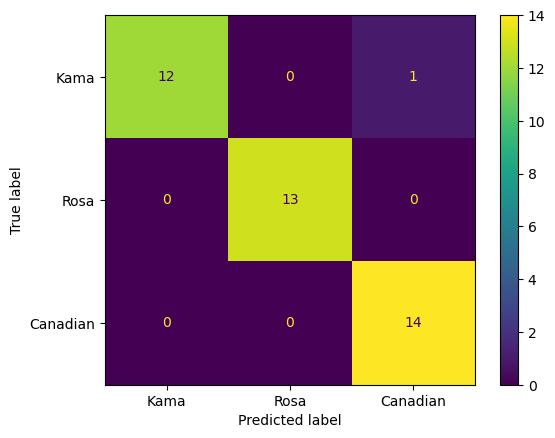

In [48]:
SVM_cm = confusion_matrix(labels_test, SVM_Model.predict(data_test))

#Graph the Confusion Matrix
SVM_cm_display = ConfusionMatrixDisplay(confusion_matrix=SVM_cm, display_labels=['Kama', 'Rosa', 'Canadian'])
SVM_cm_display.plot()

---
## Deeper look into the SVM Model
This is a seemingly very accurate model, but why? What aspects of the model describe the data well? This search is begun by reducing the dimension of the data and viewing how the different types of seed are laid out amongst each other. This is done using Principal Component Analysis and is executed below.

In [49]:
# Print the Principal Components
fully_normalized_data = normalize(data, axis=0, norm='l1')
pca = PCA(n_components=2)
X = pca.fit_transform(fully_normalized_data)

#Graph the Principal Components
colors = ['Green', 'Red', 'Blue']
color_list = [colors[labels[i]-1] for i in range(labels.shape[0])]
pca_plot = figure(title="Plot of First Two Principal Components for Wheat Seeds Dataset")
pca_plot.scatter(x=X[:,0],y=X[:,1],color=color_list)
show(pca_plot)

From the PCA, one can see that, in general, the data has distinct groups. Since SVM works be drawing lines between groups of points, clear distinctions in the data would make it more effective. To truely prove this, one would need to look at the individual features themselves. That is done below by generating a pairplot, and coloring the different seeds different colors.

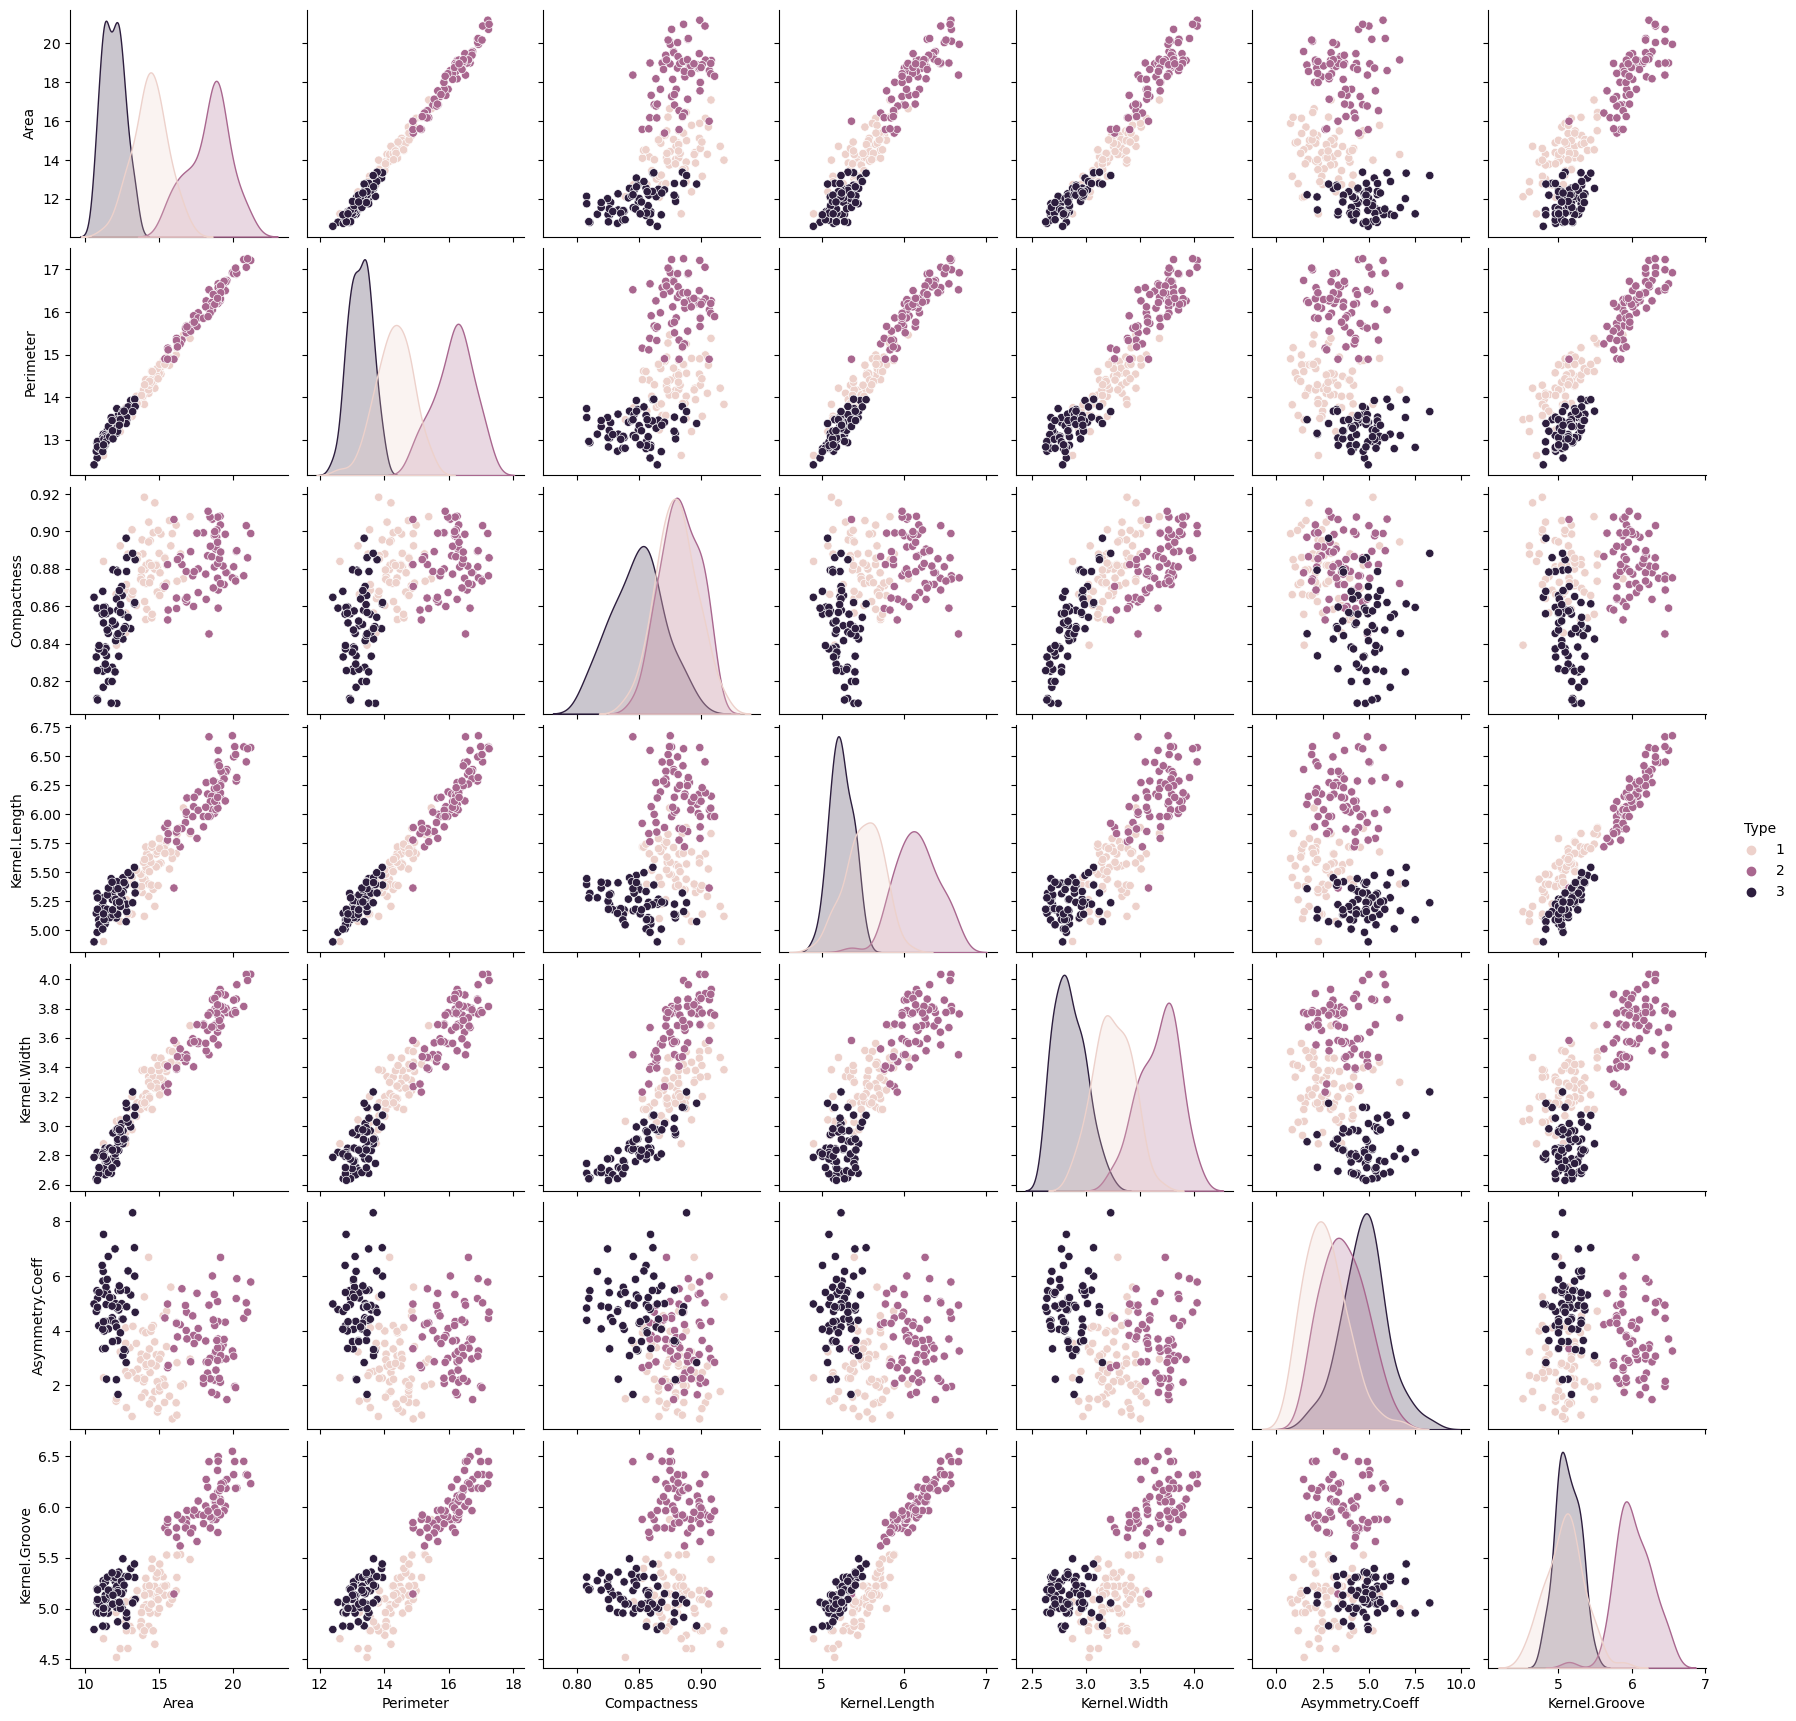

In [9]:
sns.pairplot(pandas_data, hue="Type")

Here one can really see why the SVM was effective. Many of the features produce very distinct groups, such as Kernal Length, Area, and Perimeter. Other features are less helpful for SVM, such as the asymmetric coeffient and the compactness. The SVM model can pick and choose these features and use the ones that are better at discerning the data.

---
# Random Forest Classifier 
This section focuses on the use of the Random Forest Algorithm for classification. 

In [10]:
#First we load and inspect the data
df = pd.read_csv("seeds.csv")

#check for any null values
df.isnull().values.any()

False

### Initializing and train the Random Forest Classifier
n_estimators: This parameter controls the number of trees in the forest. A higher number of trees generally leads to better performance, but also increases computation time.

max_depth: This parameter sets the maximum depth of each tree in the forest. It is used to control the complexity of the trees and prevent overfitting. A smaller value for max_depth results in simpler trees with less chance of overfitting, but may also result in lower predictive performance.

min_samples_split: This parameter sets the minimum number of samples required to split an internal node during the tree construction process. A higher value for min_samples_split can prevent overfitting and result in a more robust model. 

min_samples_leaf: This parameter sets the minimum number of samples required to be at a leaf node. A higher value for min_samples_leaf can also prevent overfitting and result in a more robust model.

After experimenting with different hyperparameter values, I found that a max_depth = 5 and min_samples_split = 5 produced the most accuracy. 


In [11]:
#Initialize the random forest classifier with the appropirate hyperparameters 
rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=5, min_samples_leaf=1)

#Fit the classifier to the training data
rf_classifier.fit(data_train, labels_train)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=500)

### Evaluate the Random Forest Model
Now we will make predictions using the model on the test data by looking at it's accuracy.

Confusion Matrix: It provides a summary of the predictions made by the model, allowing us to see how often the model correctly classified each class and how often it misclassified examples from one class as another.

Accuracy: It measures the proportion of correctly predicted samples out of the total samples.


Accuracy: 0.975


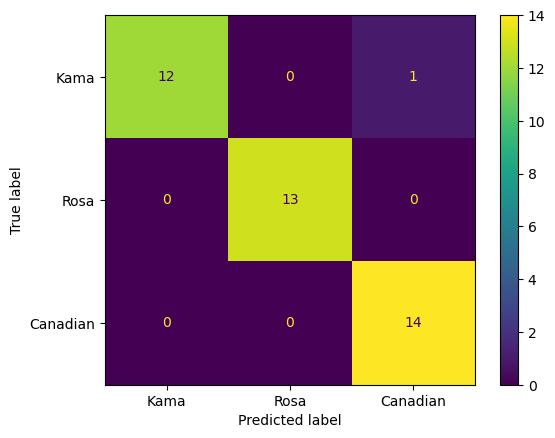

In [12]:
y_pred = rf_classifier.predict(data_test)

# Create confusion matrix
RFC_cm = confusion_matrix(labels_test, y_pred)
#Display the Confusion Matrix
RFC_cm_display = ConfusionMatrixDisplay(confusion_matrix=RFC_cm, display_labels=['Kama', 'Rosa', 'Canadian'])
RFC_cm_display.plot()

accuracy = (RFC_cm[0, 0] + RFC_cm[1, 1] + RFC_cm[2, 2]) / sum(sum(RFC_cm))

# Print accuracy
print("Accuracy:", accuracy)

### Feature Importance
Random Forest classifiers are useful for feature selection because they can estimate the importance of each feature in predicting the target variable.

In [13]:
# Get the feature importances from the trained classifier
importances = rf_classifier.feature_importances_

# Sort the features by importance (descending order)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(data.shape[1]):
    print("{}. {} ({:.3f})".format(f+1, attributes[f], importances[indices[f]]))

Feature ranking:
1. Area (0.221)
2. Perimeter (0.218)
3. Compactness (0.192)
4. Kernel.Length (0.137)
5. Kernel.Width (0.095)
6. Asymmetry.Coeff (0.074)
7. Kernel.Groove (0.063)


According to our model, the top 3 attributes used to classify wheat seeds are Area, Perimeter and Compactness. 

---

# Visulizing the Similarity and Differences Between Samples

We will now continue the discussion of the Random Forest model by generating a distance matrix for each sample.

In [14]:
df = pd.read_csv("seeds.csv") 
df.shape

(199, 8)

For each of the 199 samples in the data we will calculate it's distance by first generating the proximity matrix

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=1)
rf_model.fit(df.iloc[:, :-1].values, df.iloc[:, -1].values)
y_pred = rf_model.predict(df.iloc[:, :-1].values)

RFC_cm = confusion_matrix(df.iloc[:, -1].values, y_pred)

accuracy = (RFC_cm[0, 0] + RFC_cm[1, 1] + RFC_cm[2, 2]) / sum(sum(RFC_cm))

print("Accuracy:", accuracy)

Accuracy: 0.9899497487437185


Here is generate the proximity matrix. For each i,j in the matrix represents the number of times samples i and j landed in the same leaf node for all the 100 trees generated.

In [16]:
leaf_indices = rf_model.apply(df.iloc[:, :-1].values)

n_samples = df.iloc[:, :-1].values.shape[0]
proximity_matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(i, n_samples):
        if i == j:
            proximity_matrix[i, j] = 1.0
        else:
            shared_nodes = np.sum(leaf_indices[i] == leaf_indices[j])
            proximity_matrix[i, j] = shared_nodes / rf_model.n_estimators
            proximity_matrix[j, i] = proximity_matrix[i, j]

dist_proximity_matrix = 1 - proximity_matrix

dist_proximity_matrix


array([[0.  , 0.12, 0.3 , ..., 0.94, 1.  , 1.  ],
       [0.12, 0.  , 0.18, ..., 0.92, 1.  , 1.  ],
       [0.3 , 0.18, 0.  , ..., 0.92, 1.  , 1.  ],
       ...,
       [0.94, 0.92, 0.92, ..., 0.  , 0.88, 0.75],
       [1.  , 1.  , 1.  , ..., 0.88, 0.  , 0.38],
       [1.  , 1.  , 1.  , ..., 0.75, 0.38, 0.  ]])

The MDS plot shows some mixing between the samples, however each sample is still well separated.

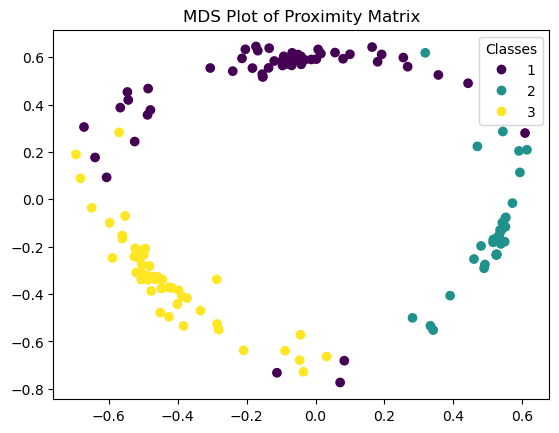

In [17]:
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(dist_proximity_matrix)

# Plot the MDS result
scatter  = plt.scatter(X_mds[:, 0], X_mds[:, 1], c=df.iloc[:, -1].values, cmap='viridis', label=["Kama", "Rosa", "Canadian"])
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title('MDS Plot of Proximity Matrix')
plt.show()

This dengogram hows that each cluster is still well separated but there is some "outliers" in the 3rd cluster indicating that different samples shared similar characteristics

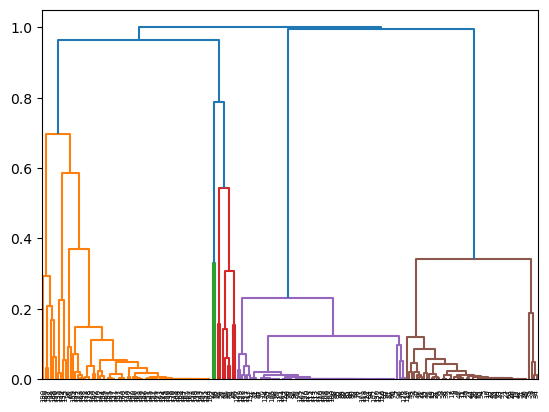

In [18]:
Z = sch.linkage(proximity_matrix, 'complete',metric='cosine')
sch.dendrogram(Z)
plt.show()

# Multiclass Logistic Regression

This model was used to better understand what makes each type of seed different/unique.


All of the different types are different significant features (perhaps what makes them stand out) for Type 1 (Kama) the most significant was Kerenel Length, for Type 2 (Rosa) it was Area and Perimeter, and for Type 3 (Canadian) it is Asymmetry

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1].values, df.iloc[:, -1].values)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logreg = LogisticRegression(multi_class='multinomial')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.92


In [20]:
pd.DataFrame(np.hstack((logreg.coef_, logreg.classes_.reshape(-1, 1))), columns=df.iloc[:, 0:-1].columns.tolist() + ["Type"])

Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0  0.062951   0.185688     0.196097       0.936569      0.152145   
1  1.003452   0.967748     0.528276       0.011280      0.918851   
2 -1.066403  -1.153437    -0.724373      -0.947849     -1.070996   

   Asymmetry.Coeff  Kernel.Groove  Type  
0        -0.830885      -1.795559   1.0  
1         0.176920       1.303744   2.0  
2         0.653965       0.491814   3.0